In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [94]:
def parse_log(file):
    match_number = re.compile('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *-?\ *[0-9]+)?')
    with open(file) as f:
        contents = f.readlines()
    times = []
    metrics = []
    testing = []
    for x in contents:
        if "Time" in x:
            value = re.findall(match_number, x)
            value = [float(v) for v in value]
            key = re.findall(r'connect_to_workers|UpdateWeight|BroadcastUpdate|ComputeAccuracy|StartComputation|Training', x)[0]
            times.append([key, value[0], value[1]])
        if "Metric" in x:
            value = re.findall(match_number, x)
            value = [float(v) for v in value]
            if 'Training' in x:
                metrics.append([value[0], value[1], value[2], value[3]])
            #if 'Testing' in x:
               #testing.append([value[0], value[1], value[2], value[3]])

    return pd.DataFrame(times, columns=['Function', 'Timestamp', 'Duration']), \
         pd.DataFrame(metrics, columns=['Timestamp', 'Iteration', 'TrainingLoss', 'WeightSize']), \
         pd.DataFrame(testing, columns=['Timestamp', 'Iteration', 'TestLoss', 'NbrSamples'])

time, metrics, testing = parse_log("worker-deployment-0.txt")

In [156]:
from os import listdir
from os.path import isfile, join

def parse_all_files(folder):
    onlyfiles = [folder+f for f in listdir(folder) if isfile(join(folder, f))]
    print(onlyfiles)
    concat_time = []
    concat_metrics = []
    concat_testing = []
    for i, file in enumerate(onlyfiles):
        if file[-3:] == "txt":
            time, metrics, testing = parse_log(file)
            time['Worker'] = i
            metrics['Worker'] = i
            testing['Worker'] = i
            concat_time.append(time)
            concat_metrics.append(metrics)
            concat_testing.append(testing)
    return pd.concat(concat_time), pd.concat(concat_metrics), pd.concat(concat_testing)

times, metrics, tests = parse_all_files('./')
#metrics.set_index('Timestamp', inplace=True)
metrics['Mean'] = pd.rolling_mean(metrics['TrainingLoss'], window=100)

['./WorkerAnalysis.ipynb', './.DS_Store', './worker-deployment-0.txt', './worker-deployment-1.txt', './worker-deployment-3.txt', './worker-deployment-2.txt', './Archive.zip']


/Users/lguillain/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=100).mean()


In [157]:
metrics['Worker'].value_counts()

4    2123
5    2118
2    2040
3     201
Name: Worker, dtype: int64

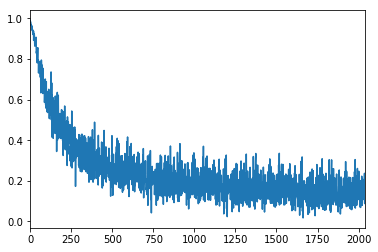

In [158]:
metrics.tail()
metrics[metrics['Worker'] == 2].TrainingLoss.plot()

In [102]:
def get_function_graphs(times):
    counts = times.groupby(['Function', 'Worker']).count()
    counts.reset_index(level=1, inplace=True)
    counts.reset_index(level=0, inplace=True)
    f = sns.factorplot(data=counts, kind='bar', x='Function',y='Duration', hue='Worker')
    f.ax.set_title("Number of function calls by function an Worker")

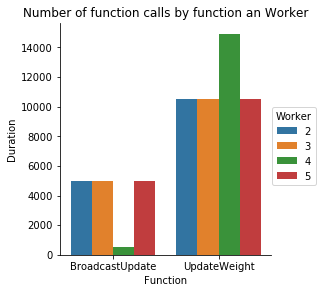

In [112]:
get_function_graphs(times)

In [113]:
def plot_metrics(metrics):
    plt.title('Increase of weight size')
    metrics.groupby('Worker')['WeightSize'].plot()
    plt.show()
    plt.title('Training loss over time')
    metrics.groupby('Worker')['TrainingLoss'].plot()
    plt.show()
    plt.title('Training loss mean over time')
    metrics.groupby('Worker')['Mean'].plot()
    plt.show()

We should use learning rate 1:

['./asynch_lr_1/worker-deployment-0.txt', './asynch_lr_1/worker-deployment-1.txt', './asynch_lr_1/worker-deployment-3.txt', './asynch_lr_1/worker-deployment-2.txt']


/Users/lguillain/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=100).mean()


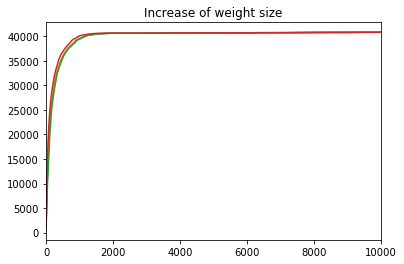

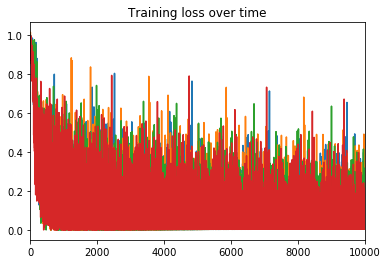

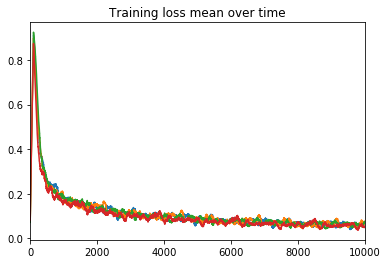

['./asynch_lr_0.1/worker-deployment-0.txt', './asynch_lr_0.1/worker-deployment-1.txt', './asynch_lr_0.1/worker-deployment-3.txt', './asynch_lr_0.1/worker-deployment-2.txt']


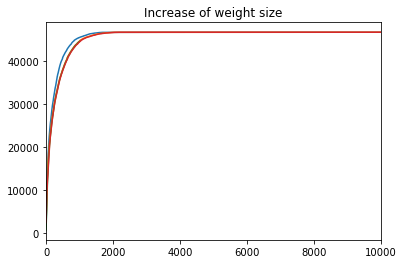

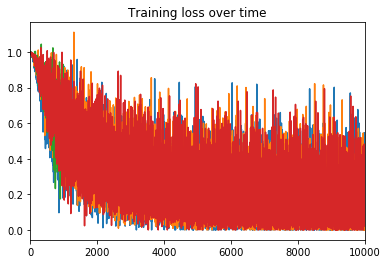

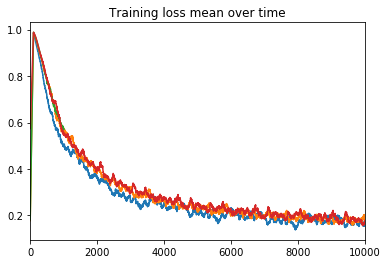

['./asynch_lr_0.01/worker-deployment-0.txt', './asynch_lr_0.01/worker-deployment-1.txt', './asynch_lr_0.01/worker-deployment-3.txt', './asynch_lr_0.01/worker-deployment-2.txt']


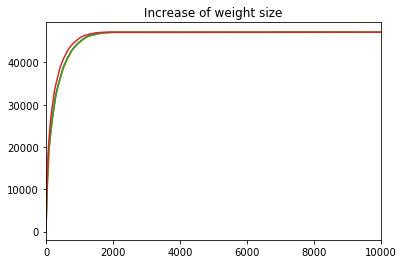

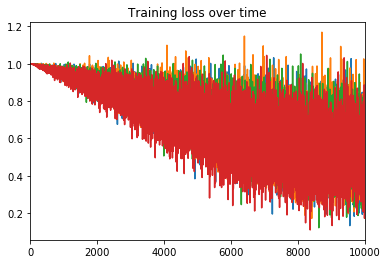

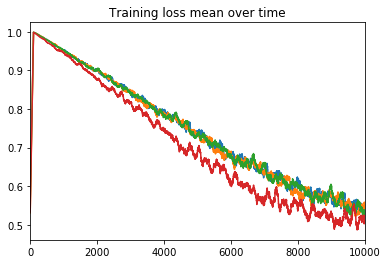

['./asynch_lr_0.001/worker-deployment-0.txt', './asynch_lr_0.001/worker-deployment-1.txt', './asynch_lr_0.001/worker-deployment-3.txt', './asynch_lr_0.001/worker-deployment-2.txt']


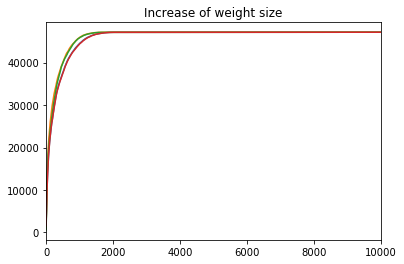

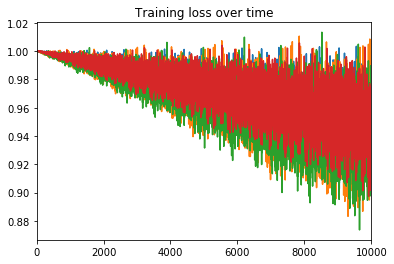

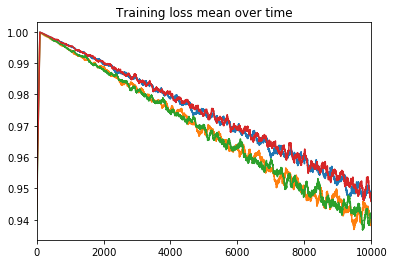

In [155]:
for i in [1, 0.1, 0.01, 0.001]:
    times, metrics, tests = parse_all_files('./asynch_lr_'+str(i)+'/')
    #metrics.set_index('Timestamp', inplace=True)
    metrics['Mean'] = pd.rolling_mean(metrics['TrainingLoss'], window=100)
    plot_metrics(metrics)